C:\Users\HP\AppData\Local\Temp\ipykernel_15264\353012815.py:89: RuntimeWarning: overflow encountered in scalar multiply
  factor = c**2/dx**2*(Psi[n,i+1]-2*Psi[n,i]+Psi[n,i-1]) - m**2*c**4*Psi[n,i] - V[n,i]*Psi[n,i]
C:\Users\HP\AppData\Local\Temp\ipykernel_15264\353012815.py:90: RuntimeWarning: invalid value encountered in scalar multiply
  Psi[n+1,i] = 2*Psi[n,i] - Psi[n-1,i] + dt**2*factor
C:\Users\HP\AppData\Local\Temp\ipykernel_15264\353012815.py:89: RuntimeWarning: overflow encountered in scalar subtract
  factor = c**2/dx**2*(Psi[n,i+1]-2*Psi[n,i]+Psi[n,i-1]) - m**2*c**4*Psi[n,i] - V[n,i]*Psi[n,i]
C:\Users\HP\AppData\Local\Temp\ipykernel_15264\353012815.py:89: RuntimeWarning: invalid value encountered in scalar multiply
  factor = c**2/dx**2*(Psi[n,i+1]-2*Psi[n,i]+Psi[n,i-1]) - m**2*c**4*Psi[n,i] - V[n,i]*Psi[n,i]


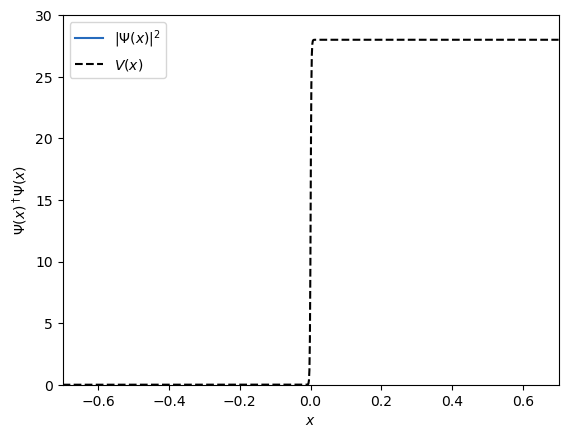

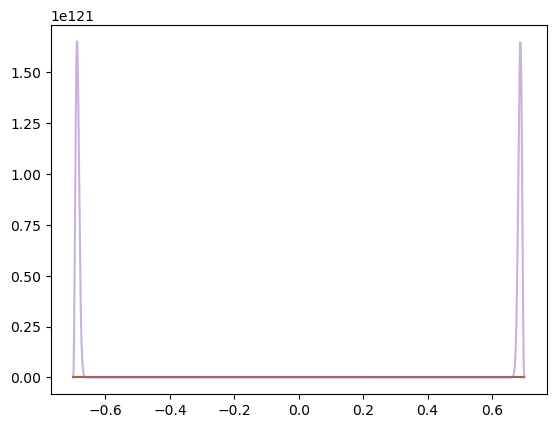

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy.linalg import multi_dot
from IPython.display import HTML

# Define the (smooth) step potential
# V(x)=0.5*V0*(tanh(x/w)+1)
def V(x, V0, w):
    return V0*0.5*(np.tanh(x/w)+1)

# Define computational grid
N = 1024
x_domain = [-0.7, 0.7]

dx = (x_domain[1] - x_domain[0]) / (N-1)     # spatial step size
x = np.linspace(x_domain[0], x_domain[1], N) # spatial grid points

c = 137                 # speed of light in atomic units (h=e=m_e=1)
dt = 1.0 / (4*c**2)     # temporal step size

dp = 2.0*np.pi / (N*dx)             # momentum step size
p = np.linspace(0, (N-1)*dp, N)     # momentum grid points
p[p>0.5*N*dp] -= N*dp               # imposing periodicity
# p = np.sort(p)

# Initial wave packet
m = 1.0     # to be changed to mass of a spin-0 particle
E = np.sqrt(p**2*c**2 + (m**2*c**4))

# Gaussian wave packet with p_mean composed of positive-energy states
x_init = -0.2               # initial position of the wave packet
p_mean = 106.4              # mean momentum
Delta_p = 0.125*c           # momentum width
Psi = np.zeros((512,N), dtype='complex')
Psi[0, :] = 1
g = 1 / (2*np.pi*Delta_p**2)**0.25 * np.exp(-(p-p_mean)**2 / (4*Delta_p**2)) * np.exp(- 1j*p*x_init)
Psi[0, :] *= g    # multiply with weight function

# go to real space (position space)
Psi = dp / np.sqrt(2*np.pi) * np.exp(1j*x*p[0]) * np.fft.ifft(np.exp(1j*x[0]*np.arange(0, N)*dp)*Psi, axis=1)*N

# initialize the potential barrier
V0 = 2 *c**2 + 1e4  # potential height
w = 0.3 / c          # potential width
V_x = V(x, V0, w)    # compute potential function

V = np.ones((512,N), dtype='complex')
V *= V_x

# First step approximation
for i in range(1, N-1):
    ddt_Psi = c**2/dx**2*(Psi[0,i+1]-2*Psi[0,i]+Psi[0,i-1]) - m**2*c**4*Psi[0,i] - V[0,i]*Psi[0,i]
    correction = 0.5*dt**2*ddt_Psi

Psi[1, :] = Psi[0, :] + correction

# fig, ax = plt.subplots()
# ax.plot(x, np.abs(Psi[0,:])**2, alpha=0.5)
# ax.plot(x, np.abs(Psi[1,:])**2, alpha=0.5, marker='o')
# # ax.show()

# Normalize V(x) for visualization (scaling factor for visibility)
V_x = V_x / np.max(V_x) * 28  # Scale to be within (0,5) for plotting

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(x_domain[0], x_domain[1])
ax.set_ylim(0, 30)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\Psi(x)^\dagger\Psi(x)$')

# Plot elements
line_prob, = ax.plot([], [], color="#266bbd", label=r'$|\Psi(x)|^2$')
ax.plot(x, V_x, color='black', linestyle='--', label=r'$V(x)$') # potential barrier
ax.legend(loc='upper left')

# Initialization function
def init():
    line_prob.set_data([], [])
    return line_prob,

# initialize propability
probability_KG = []

# Leapfrog Algorithm
for n in range(1, 511):
    for i in range(1, N-1):
        factor = c**2/dx**2*(Psi[n,i+1]-2*Psi[n,i]+Psi[n,i-1]) - m**2*c**4*Psi[n,i] - V[n,i]*Psi[n,i]
        Psi[n+1,i] = 2*Psi[n,i] - Psi[n-1,i] + dt**2*factor

fig, ax = plt.subplots()
ax.plot(x, np.abs(Psi[0,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[1,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[10,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[20,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[100,:])**2, alpha=0.5)
# ax.set_xlim(-0.2,0)
# ax.show()

# # Update function
# def update(frame):
#     global Psi

#     # # compute total probability
#     # P_t = np.sum(np.abs(Psi[0,:])**2 - np.abs(Psi[1,:])**2) * dx
#     # probability_KG.append(P_t.real)  # Store probability for plotting

#     line_prob.set_data(x, np.abs(Psi[frame,:])**2)

#     return line_prob,

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=512, init_func=init, blit=True)

# # Show the animation
# HTML(ani.to_jshtml())
# # plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy.linalg import multi_dot
from IPython.display import HTML

# Define the (smooth) step potential
# V(x)=0.5*V0*(tanh(x/w)+1)
def V(x, V0, w):
    return V0*0.5*(np.tanh(x/w)+1)*0

# Define computational grid
N = 1024
x_domain = [-0.7, 0.7]

dx = (x_domain[1] - x_domain[0]) / (N-1)     # spatial step size
x = np.linspace(x_domain[0], x_domain[1], N) # spatial grid points

c = 137                 # speed of light in atomic units (h=e=m_e=1)
dt = 1.0 / (4*c**2)     # temporal step size

dp = 2.0*np.pi / (N*dx)             # momentum step size
p = np.linspace(0, (N-1)*dp, N)     # momentum grid points
p[p>0.5*N*dp] -= N*dp               # imposing periodicity
# p = np.sort(p)

# Initial wave packet
m = 1.0     # to be changed to mass of a spin-0 particle
E = np.sqrt(p**2*c**2 + (m**2*c**4))

# Gaussian wave packet with p_mean composed of positive-energy states
x_init = -0.2               # initial position of the wave packet
p_mean = 106.4              # mean momentum
Delta_p = 0.125*c           # momentum width
Psi = np.zeros((512,N), dtype='complex')
Psi[0, :] = 1
g = 1 / (2*np.pi*Delta_p**2)**0.25 * np.exp(-(p-p_mean)**2 / (4*Delta_p**2)) * np.exp(- 1j*p*x_init)
Psi[0, :] *= g    # multiply with weight function

# go to real space (position space)
Psi = dp / np.sqrt(2*np.pi) * np.exp(1j*x*p[0]) * np.fft.ifft(np.exp(1j*x[0]*np.arange(0, N)*dp)*Psi, axis=1)*N

# initialize the potential barrier
V0 = 2 *c**2 + 1e4  # potential height
w = 0.3 / c          # potential width
V_x = V(x, V0, w)    # compute potential function

V = np.zeros((512,N), dtype='complex')
V[0, :] = V_x

# First step approximation
for i in range(1, N-1):
    ddt_Psi = c**2/dx**2*(Psi[0,i+1]-2*Psi[0,i]+Psi[0,i-1]) - m**2*c**4*Psi[0,i] - V[0,i]*Psi[0,i]
    correction = 0.5*dt**2*ddt_Psi

Psi[1, :] = Psi[0, :] + correction

fig, ax = plt.subplots()
ax.plot(x, np.abs(Psi[0,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[1,:])**2, alpha=0.5, marker='o')
# ax.show()

# Normalize V(x) for visualization (scaling factor for visibility)
V_x = V_x / np.max(V_x) * 28  # Scale to be within (0,5) for plotting

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(x_domain[0], x_domain[1])
ax.set_ylim(0, 30)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\Psi(x)^\dagger\Psi(x)$')

# Plot elements
line_prob, = ax.plot([], [], color="#266bbd", label=r'$|\Psi(x)|^2$')
ax.plot(x, V_x, color='black', linestyle='--', label=r'$V(x)$') # potential barrier
ax.legend(loc='upper left')

# Initialization function
def init():
    line_prob.set_data([], [])
    return line_prob,

# initialize propability
probability_KG = []

# Leapfrog Algorithm
for n in range(1, 511):
    for i in range(1, N-1):
        factor = c**2/dx**2*(Psi[n,i+1]-2*Psi[n,i]+Psi[n,i-1]) - m**2*c**4*Psi[n,i] - V[0,i]*Psi[n,i]
        Psi[n+1,i] = 2*Psi[n,i] - Psi[n-1,i] + dt**2*factor

fig, ax = plt.subplots()
ax.plot(x, np.abs(Psi[0,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[10,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[20,:])**2, alpha=0.5)
ax.plot(x, np.abs(Psi[100,:])**2, alpha=0.5)
# ax.set_xlim(-0.2,0)
# ax.show()

# # Update function
# def update(frame):
#     global Psi

#     # # compute total probability
#     # P_t = np.sum(np.abs(Psi[0,:])**2 - np.abs(Psi[1,:])**2) * dx
#     # probability_KG.append(P_t.real)  # Store probability for plotting

#     line_prob.set_data(x, np.abs(Psi[frame,:])**2)

#     return line_prob,

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=512, init_func=init, blit=True)

# # Show the animation
# HTML(ani.to_jshtml())
# # plt.show()